# Random Forest + LIBRAS

This notebook covers a Python-based solution to be compared to the experiments 1 to 4 presented in <cite data-cite="6013574/XD5B9TZQ"></cite>.

The presented solution consists in reproducing the feature vectors for each of the experiments utilizing (x, y) points in <cite data-cite="6013574/XD5B9TZQ"></cite>, applying a RandomForest classifier, and lastly, comparing the resulting performance to the ones obtained by SVM and k-NN approaches.

## Context

\# TO DO

## Dataset

\# TO DO

## Experiments

\# TO DO

In [1]:
import glob as gl
import numpy as np
from scipy.io import loadmat
from typing import List
import pandas as pd

In [2]:
def labelname(file_name):  # Extract labels from filenames 
    label = file_name.replace("data/fundamental/sample", "").lower()
    label = label.replace(".mat", "").lower()
    label = label.split('-', 1)[-1]
    return label


class Signal:  # Signal representation containing x and y coordinates and corresponding label
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

### Experiment 1

The first experiment utilizes each signal in its raw form.

In [3]:
def sigvalues(sig):  # EX.1: raw data
    updsig = np.zeros((np.shape(sig.x)[0], np.shape(sig.x)[1] * 2))
    updsig[:, ::2] = sig.x
    updsig[:, 1::2] = sig.y

    return updsig  # Updated signal

### Experiment 2

The second experiment consists of applying z-normalization to each sample. The updated coordinates are:
\begin{align}
x_{\mathcal{N(0,1)}}=\frac{x-\bar{x}}{\sigma(x)} \\
y_{\mathcal{N(0,1)}}=\frac{y-\bar{y}}{\sigma(y)}
\end{align}


In [ ]:
def sigvalues(sig):  # EX.2: z-norm
    updsig = np.zeros((np.shape(sig.x)[0], np.shape(sig.x)[1] * 2))
    for idx, x in enumerate(sig.x):
        sig.x[idx] = np.divide((np.transpose(x) - np.mean(x)), np.std(x))
    for idx, y in enumerate(sig.y):
        sig.y[idx] = np.divide((np.transpose(y) - np.mean(y)), np.std(y))

    updsig[:, ::2] = sig.x
    updsig[:, 1::2] = sig.y

    return updsig  # Updated signal

### Experiment 3

The third experiment consists of normalizing each signal by its 1st frame centroid, as follows:
\begin{align}
\tilde{x}_{P,f}=x_{P,f}-\bar{x}_{1} \\
\tilde{y}_{P,f}=y_{P,f}-\bar{y}_{1}
\end{align}

In [ ]:
def sigvalues(sig): # EX.3: norm by 1st frame centroid
    frame_x = np.split(sig.x, 5, axis=1)  # x-coordinates by frame
    frame_y = np.split(sig.y, 5, axis=1)  # y-coordinates by frame
    cent_x, cent_y = (np.mean(frame_x[0], axis=1), np.mean(frame_y[0], axis=1))  # first frame centroid of each recording

    updsig = np.zeros((np.shape(sig.x)[0], np.shape(sig.x)[1] * 2))
    for idx, x in enumerate(sig.x):
        sig.x[idx] = x - cent_x[idx]
    for idx, y in enumerate(sig.y):
        sig.y[idx] = y - cent_y[idx]

    updsig[:, ::2] = sig.x
    updsig[:, 1::2] = sig.y

    return updsig  # Updated signal

### Experiment 4

The fourth experiment consists of normalizing each signal by its current frame centroid, as follows:
\begin{align}
\tilde{x}_{P,f}=x_{P,f}-\bar{x}_{f} \\
\tilde{y}_{P,f}=y_{P,f}-\bar{y}_{f}
\end{align}

In [ ]:
def sigvalues(sig):  # EX.4
    frame_x = np.split(sig.x, 5, axis=1)  # x-coordinates by frame
    frame_y = np.split(sig.y, 5, axis=1)  # y-coordinates by frame
    cent_x, cent_y = (np.mean(frame_x, axis=2), np.mean(frame_y, axis=2))  # centroids of each recording

    nframes, nrecs, idx = np.shape(frame_x)
    updsig = np.zeros((np.shape(sig.x)[0], np.shape(sig.x)[1] * 2))
    for fx in range(nframes):
        frame_x[fx] = np.transpose(np.transpose(frame_x[fx]) - cent_x[fx])
    for fy in range(nframes):
        frame_y[fy] = np.transpose(np.transpose(frame_y[fy]) - cent_y[fy])

    updsig[:, ::2] = np.hstack(frame_x)
    updsig[:, 1::2] = np.hstack(frame_y)

    return updsig  # Updated signal

## Classification

For means of comparison, this solution utilizes the Random Forest algorithm for the classification task. Tuning is done on every iteration utilizing GridSearchCV. 

In [4]:
files = gl.glob("data/fundamental/*.mat")  # type: list

signals = []  # type: List[Signal]

for f in files:
    data = loadmat(f).get('pontosSinal')
    signals.append(Signal(data[:, ::2], data[:, 1::2], labelname(f)))

n_signs = len(signals)
n_recs, n_x = np.shape(signals[0].x)  # Number of recordings and number of features

signals_feat = []  # Updated signals, according to each experiment
signals_labels = []
labels_dict = {'angry': 1, 'disgusted': 2, 'fearful': 3, 'happy': 4, 'sad': 5, 'surprised': 6, 
               'neutral': 7, 'suckedcheeks': 8, 'inflatedcheeks': 9}  # Dictionary of signals' labels, for reference
for s in signals:
    signals_feat.append(sigvalues(s))
    signals_labels.append([labels_dict[s.label]] * n_recs)
    
sig_features = np.reshape(signals_feat, (n_signs * n_recs, n_x * 2))
sig_labels = np.reshape(signals_labels, (n_signs * n_recs,))

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from pprint import pprint

\# TO DO: PARAMETER SELECTION

In [6]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=800, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 0.3]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num=10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
              }

\# TO DO

In [8]:
# cv = 5
niter = 30
results = []
train_acc = []
test_acc = []
train_report =[]
class_report = []
selected_params = []
cm = [] # confusion matrix
feature_importance = []
col_names = range(1,1211)

for i in range(niter):
    print("Iteration:: ", i)
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    sss.get_n_splits(sig_features, sig_labels)

    for train_index, test_index in sss.split(sig_features, sig_labels):
        train_x, test_x = sig_features[train_index], sig_features[test_index]
        train_y, test_y = sig_labels[train_index], sig_labels[test_index]

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=500, cv=3, verbose=1, n_jobs=-1)

    rf_random.fit(train_x, train_y)
    predictions = rf_random.predict(test_x)
    
    selected_params.append(rf_random.best_params_)
    train_acc.append(accuracy_score(train_y, rf_random.predict(train_x)))
    test_acc.append(accuracy_score(test_y, predictions))
    cm.append(pd.crosstab(test_y, predictions, rownames=['True'], colnames=['Predicted'], margins=True))
    class_report.append(classification_report(test_y, predictions, target_names=list(labels_dict.keys())))
    feature_importance.append(pd.DataFrame(data=sorted(zip(map(lambda x: round(x, 4), 
                                                               rf_random.best_estimator_.feature_importances_), 
                                                           col_names), reverse=True)))

Iteration::  0
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 48.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 60.2min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  1
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 53.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  2
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 57.6min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  3
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 58.7min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  4
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 60.7min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  5
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 49.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 60.6min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  6
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 47.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 56.6min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  7
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 55.0min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  8
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 56.4min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  9
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 48.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 57.8min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  10
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 57.9min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  11
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 48.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 58.4min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  12
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 47.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 56.0min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  13
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 37.1min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  14
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 29.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  15
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 29.4min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  16
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 26.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  17
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 26.2min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  18
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 30.9min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  19
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 54.8min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  20
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 55.6min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  21
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 58.5min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  22
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 47.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 57.7min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  23
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 59.3min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  24
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 45.3min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 55.0min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  25
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 57.8min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  26
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 45.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 54.0min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  27
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 47.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 57.0min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  28
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 57.2min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


Iteration::  29
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 55.2min finished
C:\Users\rubiarg\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 9
  .format(len(labels), len(target_names))


## Results

In [10]:
from functools import reduce

conf_matrix = reduce(lambda x, y: x.add(y, fill_value=0), cm)

np.savetxt("results/thesis/raw-trainacc.csv",train_acc,delimiter=",")
np.savetxt("results/thesis/raw-testacc.csv",test_acc,delimiter=",")
np.savetxt("results/thesis/raw-selected_params.txt",selected_params,fmt='%s',delimiter='\n')
np.savetxt("results/thesis/raw-classreport.txt",class_report,fmt='%s',delimiter='\n')
conf_matrix.to_csv("results/thesis/raw-cm.csv")

import pickle
with open('results/thesis/raw-featimportance.pickle', 'wb') as fp:
    for feat in feature_importance:
        pickle.dump(feat, fp)

<IPython.core.display.Javascript object>


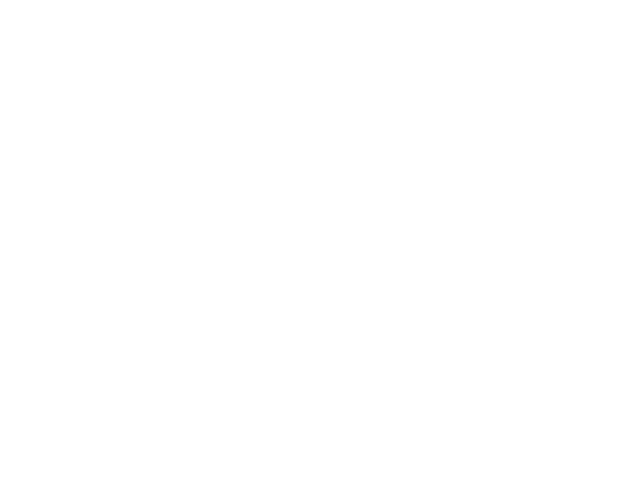

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
acc = np.transpose([train_acc, test_acc])
acc = pd.DataFrame(data=acc, columns=['train_acc', 'test_acc'])
boxplot = acc.boxplot(column=['train_acc', 'test_acc'])
plt.show()

In [12]:
acc.describe()

,train_acc,test_acc
count,30.000000,3.000000e+01
mean,0.999583,8.000000e-01
std,0.002282,2.258405e-16
min,0.987500,8.000000e-01
25%,1.000000,8.000000e-01
50%,1.000000,8.000000e-01
75%,1.000000,8.000000e-01
max,1.000000,8.000000e-01


# References

<div class="cite2c-biblio"></div>